In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats

import argus_shapes
import pulse2percept.implants as p2pi

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-26 18:01:14,610 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
subject_params = {
    'TB': {
        'implant_type': p2pi.ArgusI,
        'implant_x': -1527,
        'implant_y': -556,
        'implant_rot': -1.13,
        'loc_od_x': 13.6,
        'loc_od_y': 0.0,
        'xrange': (-36.9, 36.9),
        'yrange': (-36.9, 36.9)
    },
    '12-005': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -1761,
        'implant_y': -212,
        'implant_rot': -0.188,
        'loc_od_x': 15.4,
        'loc_od_y': 1.86,
        'xrange': (-30, 30),
        'yrange': (-22.5, 22.5)
    },
    '51-009': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -799,
        'implant_y': 93,
        'implant_rot': -1.09,
        'loc_od_x': 15.7,
        'loc_od_y': 0.75,
        'xrange': (-32.5, 32.5),
        'yrange': (-24.4, 24.4)
    },
    '52-001': {
        'implant_type': p2pi.ArgusII,
        'implant_x': -1230,
        'implant_y': 415,
        'implant_rot': -0.457,
        'loc_od_x': 15.9,
        'loc_od_y': 1.96,
        'xrange': (-32, 32),
        'yrange': (-24, 24)
    }
}

use_electrodes = {
    'TB': ['A4', 'C2', 'C3', 'C4', 'D2', 'D3', 'B3', 'D4'],
    '12-005': ['A04', 'A06', 'B03', 'C07', 'C10', 'D07', 'D08', 'D10',
               'F06'],
    '51-009': ['A02', 'C01', 'C05', 'C06', 'D03', 'E01', 'E05', 'E07',
               'F04', 'F06'],
    '52-001': ['A05', 'A07', 'B09', 'A10', 'C10', 'D05', 'D07', 'E04',
               'E09', 'E10', 'F06', 'F07', 'F08', 'F09', 'F10']
}

In [3]:
subjects = ['TB', '12-005', '51-009', '52-001']

In [4]:
datafolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')
features = []
targets = []
for subject in subjects:
    f, t = argus_shapes.load_data(datafolder, subject=subject,
                                electrodes=use_electrodes[subject],
                                amplitude=2.0, random_state=42)
    xyrange = np.array([np.diff(subject_params[subject]['xrange'])[0],
                        np.diff(subject_params[subject]['yrange'])[0]])
    t['area'] = [y['area'] / np.prod(x['img_shape']) * np.prod(xyrange)
                 for (_, x), (_, y) in zip(f.iterrows(), t.iterrows())]
    t['orientation'] = np.rad2deg(t['orientation'])
    t['compactness'] = 1.0 / (t['compactness'] / (4 * np.pi))
    t['electrode'] = ['%s%d' % (row['electrode'][0], int(row['electrode'][1:]))
                      for _, row in t.iterrows()]
    features.append(f)
    targets.append(t)

In [5]:
Xy = pd.concat((pd.concat(features), pd.concat(targets).drop(columns='electrode')), axis=1)

In [6]:
cols = ['area', 'orientation', 'eccentricity', 'compactness']
ylabels = ['area (deg$^2$)', 'orientation (rad)', 'eccentricity', 'compactness']
markers = ['o', 's', 'v', '^']
# colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']

# Fig. 4A: Shape descriptors

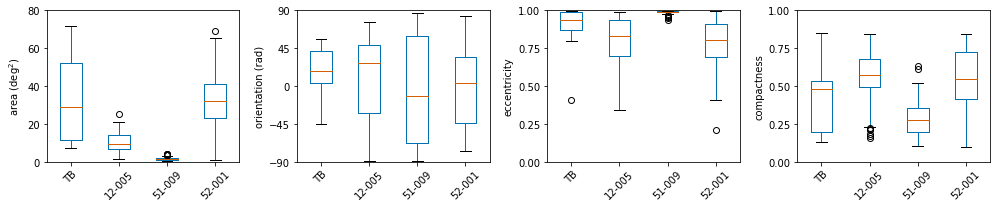

In [7]:
ylimits = [[0, 80], [-90, 90], [0, 1], [0, 1]]

fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim in zip(cols, axes, ylabels, ylimits):
    gb = Xy.loc[:, ['subject', col]].groupby('subject', sort=False)
    gb.boxplot(subplots=False, grid=False, rot=45, ax=ax)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=5))
    ax.set_xticklabels(subjects)
    ax.set_ylabel(ylabel)
fig.tight_layout()
fig.savefig('fig4a-shape-descriptors.png')
fig.savefig('fig4a-shape-descriptors.eps')

# Fig. 4B: Shape variability

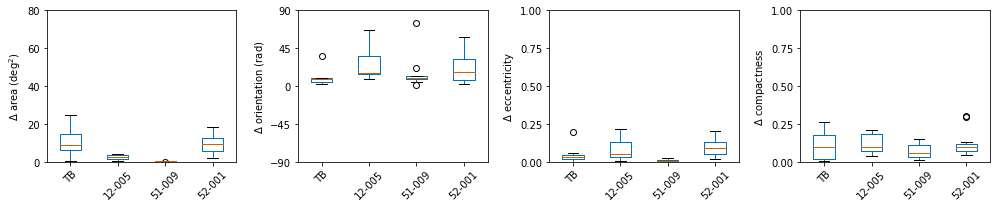

In [8]:
ylimits = [[0, 80], [-90, 90], [0, 1], [0, 1]]

fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim in zip(cols, axes, ylabels, ylimits):
    gb = Xy.loc[:, ['subject', 'electrode', col]].groupby(['subject', 'electrode'], sort=False)
    ggb = gb.std().groupby('subject')
    ggb.boxplot(subplots=False, grid=False, rot=45, ax=ax)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=5))
    ax.set_xticklabels(subjects)
    ax.set_ylabel('$\Delta$ %s' % ylabel)
fig.tight_layout()
fig.savefig('fig4b-shape-variability.png')
fig.savefig('fig4b-shape-variability.eps')